In [1]:
!git clone https://github.com/iiscleap/Coswara-Data.git
%cd Coswara-Data

# Instructions
# You need Google Colab Pro to run this
# Upload the Provided csv file along before running shuttling operations
# Plz run on GPU only
# This takes very long to run. You have to download the dataset > extract  > Preprocess > Reorder > Download pretrained models > Train > Inference

# References
#https://github.com/pytorch/audio/issues/1023
# https://www.fatalerrors.org/a/0N112TE.html
# https://colab.research.google.com/drive/172TfOusbVN4y6f3sZGgTovSpVA53Aa9u?usp=sharing
#https://www.kaggle.com/sreevishnudamodaran/siim-covid19-fastai-efficientnetv2-timm 
# # https://github.com/rwightman/pytorch-image-models
# https://medium.com/geekculture/train-a-pytorch-efficientnet-model-for-medical-diagnosis-1d000c540bd

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 762 (delta 14), reused 33 (delta 11), pack-reused 726
Receiving objects: 100% (762/762), 13.99 GiB | 41.73 MiB/s, done.
Resolving deltas: 100% (301/301), done.
Checking out files: 100% (178/178), done.
/content/Coswara-Data


In [2]:
!python extract_data.py

Streaming output truncated to the last 5000 lines.
20210419/gpc5ZdD5pOa7ytps4CYAFQASQcC2/vowel-a.wav
20210419/gpc5ZdD5pOa7ytps4CYAFQASQcC2/vowel-e.wav
20210419/gpc5ZdD5pOa7ytps4CYAFQASQcC2/breathing-shallow.wav
20210419/gpc5ZdD5pOa7ytps4CYAFQASQcC2/counting-fast.wav
20210419/gpc5ZdD5pOa7ytps4CYAFQASQcC2/breathing-deep.wav
20210419/gpc5ZdD5pOa7ytps4CYAFQASQcC2/cough-heavy.wav
20210419/gpc5ZdD5pOa7ytps4CYAFQASQcC2/cough-shallow.wav
20210419/uuYtRprLjWhFilZnNmWCH0wcT5v2/counting-normal.wav
20210419/uuYtRprLjWhFilZnNmWCH0wcT5v2/metadata.json
20210419/uuYtRprLjWhFilZnNmWCH0wcT5v2/vowel-o.wav
20210419/uuYtRprLjWhFilZnNmWCH0wcT5v2/vowel-a.wav
20210419/uuYtRprLjWhFilZnNmWCH0wcT5v2/vowel-e.wav
20210419/uuYtRprLjWhFilZnNmWCH0wcT5v2/breathing-shallow.wav
20210419/uuYtRprLjWhFilZnNmWCH0wcT5v2/counting-fast.wav
20210419/uuYtRprLjWhFilZnNmWCH0wcT5v2/breathing-deep.wav
20210419/uuYtRprLjWhFilZnNmWCH0wcT5v2/cough-heavy.wav
20210419/uuYtRprLjWhFilZnNmWCH0wcT5v2/cough-shallow.wav
20210419/dLWRBpUZo7ddqJ

In [3]:
import os
from pathlib import Path
import shutil

import librosa
import librosa.display
import numpy as np
import tqdm
from matplotlib import pyplot as plt
from PIL import Image


def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled


def extract_spectrogram_image(file_path, out_path, sr=22050, time_steps=384,
                              duration=5, hop_length=512, n_mels=128):
    y, sr = librosa.load(file_path, duration=duration, sr=sr)

    # extract a fixed length window
    start_sample = 0  # starting at beginning
    length_samples = time_steps*hop_length
    window = y[start_sample:start_sample+length_samples]

    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=window, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9)  # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255 - img # invert. make black==more energy

    # save as PNG
    # skimage.io.imsave(out, img)
    Image.fromarray(img).save(out_path)

out_dir = 'Coswara-Processed'
out_image_dir = os.path.join(out_dir, 'images')
os.makedirs(out_image_dir, exist_ok=True)
!rm -rf {out_dir}

data_dir = Path('Extracted_data')
audio_files = list(data_dir.glob('*/*/cough-*.wav'))
label_file = 'combined_data.csv'

mono = True
duration = 5
sr = 22050
n_mels = 128  # The height
time_steps = 384  # The width
hop_length = 512
error_cases = []
for file_path in tqdm.tqdm(audio_files):
    file_path = str(file_path)

    # Build output file path
    filename = os.path.splitext(os.path.basename(file_path))[0]
    user_id = file_path.split(os.sep)[-2]
    out_user_dir = os.path.join(out_image_dir, user_id)
    if not os.path.exists(out_user_dir):
        os.makedirs(out_user_dir, exist_ok=True)
    out_path = os.path.join(out_user_dir, filename + '.png')

    if os.path.exists(out_path):
        continue

    try:
        extract_spectrogram_image(file_path, out_path, sr, time_steps, duration, hop_length, n_mels)
    except Exception as e:
        print(f'Failed while processing {file_path} with exception: {e}')
        error_cases.append(user_id)
        shutil.rmtree(out_user_dir)

  0%|          | 16/4465 [00:05<21:01,  3.53it/s]

Failed while processing Extracted_data/20200418/C7Km0KttQRMMM6UoyocajfgZAOB3/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200418/C7Km0KttQRMMM6UoyocajfgZAOB3/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


  3%|▎         | 114/4465 [00:30<20:21,  3.56it/s]

Failed while processing Extracted_data/20200803/8Iug9hOgiBZTCKZuDxazXlamW0g1/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200803/8Iug9hOgiBZTCKZuDxazXlamW0g1/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


  3%|▎         | 124/4465 [00:33<19:45,  3.66it/s]

Failed while processing Extracted_data/20200803/zFDUIa5rb2OG7IXXSI5vXVsoLa32/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200803/zFDUIa5rb2OG7IXXSI5vXVsoLa32/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


  9%|▉         | 402/4465 [01:46<17:35,  3.85it/s]

Failed while processing Extracted_data/20200814/kgjTguvo3vZJTO7F1qO9GxEicbA3/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200814/kgjTguvo3vZJTO7F1qO9GxEicbA3/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


  9%|▉         | 406/4465 [01:47<13:05,  5.17it/s]

Failed while processing Extracted_data/20200814/JUVJnOVJKKcdzppK3hkci4TO4ij1/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200814/JUVJnOVJKKcdzppK3hkci4TO4ij1/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


  9%|▉         | 412/4465 [01:48<13:31,  5.00it/s]

Failed while processing Extracted_data/20200814/DycfRd7vyobY2PgwT3rQOemSbP53/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200814/DycfRd7vyobY2PgwT3rQOemSbP53/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 11%|█         | 480/4465 [02:04<18:15,  3.64it/s]

Failed while processing Extracted_data/20200814/Ts5Rbl9h9pWKqCQPJwoTduGvjMm2/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200814/Ts5Rbl9h9pWKqCQPJwoTduGvjMm2/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 14%|█▎        | 606/4465 [02:37<16:56,  3.80it/s]

Failed while processing Extracted_data/20210816/WcRpZenx0WWQmzOUPTHEEGlyJAg1/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 48000->22050


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
 22%|██▏       | 981/4465 [04:17<13:38,  4.26it/s]

Failed while processing Extracted_data/20210406/c18b81Qa5YY2RbEzblDNxMNQE312/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 22%|██▏       | 992/4465 [04:20<13:13,  4.38it/s]

Failed while processing Extracted_data/20200824/pBBuvcoBj7hjmNVYFICT4hQYRGw1/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 48000->22050
Failed while processing Extracted_data/20200824/pBBuvcoBj7hjmNVYFICT4hQYRGw1/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 27%|██▋       | 1188/4465 [05:07<13:32,  4.03it/s]

Failed while processing Extracted_data/20200525/8Suz7Jl7GtXpdB7UeIPtLuZb1Lp2/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200525/8Suz7Jl7GtXpdB7UeIPtLuZb1Lp2/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 30%|██▉       | 1323/4465 [05:41<12:57,  4.04it/s]

Failed while processing Extracted_data/20200430/C3luMlCgAFZqGmGjFscXe9fVHSG3/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 46%|████▌     | 2056/4465 [08:56<11:34,  3.47it/s]

Failed while processing Extracted_data/20200416/9Rhe6RDHuMNXaGiqKVaspw71Exo1/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200416/9Rhe6RDHuMNXaGiqKVaspw71Exo1/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 47%|████▋     | 2080/4465 [09:02<11:29,  3.46it/s]

Failed while processing Extracted_data/20200416/cbmcTV6z0NVgO0i6yeYyAO7AoI72/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200416/cbmcTV6z0NVgO0i6yeYyAO7AoI72/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 47%|████▋     | 2095/4465 [09:06<10:34,  3.74it/s]

Failed while processing Extracted_data/20200416/sbdVe2aEGKeFcPXdhSf5QOuA5qA3/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200416/sbdVe2aEGKeFcPXdhSf5QOuA5qA3/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 50%|████▉     | 2219/4465 [09:38<10:02,  3.73it/s]

Failed while processing Extracted_data/20200416/SG95RAgm0wY3bzyIZPPSpHwyYuD3/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 48000->22050
Failed while processing Extracted_data/20200416/SG95RAgm0wY3bzyIZPPSpHwyYuD3/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 52%|█████▏    | 2303/4465 [10:00<10:15,  3.51it/s]

Failed while processing Extracted_data/20200416/TLfuOcZh0HfnVRRdez4CxLFiPki2/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200416/TLfuOcZh0HfnVRRdez4CxLFiPki2/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 53%|█████▎    | 2355/4465 [10:13<09:21,  3.76it/s]

Failed while processing Extracted_data/20200416/Vq1h51z5x3Wp4wS2pCm6yEAZvu82/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200416/Vq1h51z5x3Wp4wS2pCm6yEAZvu82/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 54%|█████▎    | 2395/4465 [10:23<09:44,  3.54it/s]

Failed while processing Extracted_data/20200416/697xpWya0DbSEN4Y6tsEH3BchHw1/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200416/697xpWya0DbSEN4Y6tsEH3BchHw1/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 54%|█████▍    | 2421/4465 [10:30<09:35,  3.55it/s]

Failed while processing Extracted_data/20200419/XFX3DxpzWlTsqde0wmliVzvRXnf1/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200419/XFX3DxpzWlTsqde0wmliVzvRXnf1/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 62%|██████▏   | 2776/4465 [12:03<06:22,  4.42it/s]

Failed while processing Extracted_data/20200415/f9g4olEAspen4dJakQJsI2EME032/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 63%|██████▎   | 2797/4465 [12:08<07:29,  3.71it/s]

Failed while processing Extracted_data/20200415/jSb7SyucSmTHhzs3qQoBExRMQZ02/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 64%|██████▍   | 2863/4465 [12:23<06:51,  3.90it/s]

Failed while processing Extracted_data/20200820/Tfvspm3rapd3ZLyAoMG36VxNQnr2/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200820/Tfvspm3rapd3ZLyAoMG36VxNQnr2/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 64%|██████▍   | 2871/4465 [12:25<06:45,  3.93it/s]

Failed while processing Extracted_data/20200820/aU8pLZV1OUQJV0GKeeIlgWhYWeA2/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 65%|██████▌   | 2904/4465 [12:33<07:02,  3.69it/s]

Failed while processing Extracted_data/20210830/r7mpJTuaZYNE7L4ohPsXiqLbba93/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 66%|██████▌   | 2937/4465 [12:42<07:13,  3.52it/s]

Failed while processing Extracted_data/20210830/mdnBfPM4iLX7S1O9v92lao51Agz1/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 66%|██████▌   | 2958/4465 [12:47<06:34,  3.82it/s]

Failed while processing Extracted_data/20210830/plyCfBNtOnbjBXIVa996Dq1EJ5u2/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 66%|██████▋   | 2960/4465 [12:47<04:51,  5.16it/s]

Failed while processing Extracted_data/20210830/EcZEa8IomxYk9MmRANz215imk8N2/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 67%|██████▋   | 2998/4465 [12:56<05:52,  4.17it/s]

Failed while processing Extracted_data/20210830/OC99RqHzOjNvaA0rJhPUgP4PM2o1/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 71%|███████   | 3149/4465 [13:36<04:51,  4.51it/s]

Failed while processing Extracted_data/20200502/FJTHLyF7sGYFJpundI1mZ28HQQ03/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200502/FJTHLyF7sGYFJpundI1mZ28HQQ03/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 73%|███████▎  | 3259/4465 [14:10<05:45,  3.49it/s]

Failed while processing Extracted_data/20200502/VxQekDvwa3N5B2FqB4FlQ5jBjTp2/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200502/VxQekDvwa3N5B2FqB4FlQ5jBjTp2/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 74%|███████▎  | 3287/4465 [14:17<05:24,  3.63it/s]

Failed while processing Extracted_data/20200502/mNcNjQMsv8aZXFGuguWbLdmkOQk2/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200502/mNcNjQMsv8aZXFGuguWbLdmkOQk2/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 76%|███████▌  | 3383/4465 [14:43<05:07,  3.52it/s]

Failed while processing Extracted_data/20200502/I5gTlFVoKbVFGCKxwV6QXSOdkZN2/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200502/I5gTlFVoKbVFGCKxwV6QXSOdkZN2/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 78%|███████▊  | 3499/4465 [15:12<03:56,  4.09it/s]

Failed while processing Extracted_data/20200413/TRK6gUseEUS7dbF0soG80W1uLm53/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200413/TRK6gUseEUS7dbF0soG80W1uLm53/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 79%|███████▉  | 3523/4465 [15:18<04:10,  3.76it/s]

Failed while processing Extracted_data/20200413/9XKj7fAmvwPUas9GFPZuTpev7T03/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 16000->22050
Failed while processing Extracted_data/20200413/9XKj7fAmvwPUas9GFPZuTpev7T03/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 16000->22050


 82%|████████▏ | 3657/4465 [15:53<03:12,  4.20it/s]

Failed while processing Extracted_data/20200911/CdU4pgCdFcZxtDHTpLUn1mO9J3o2/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 83%|████████▎ | 3692/4465 [16:02<03:31,  3.65it/s]

Failed while processing Extracted_data/20210914/saLiV2oREChEpRlmo4TikTNRuZV2/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 83%|████████▎ | 3724/4465 [16:10<03:19,  3.71it/s]

Failed while processing Extracted_data/20210914/lMENbuoFgAdokwyJxN0RiDDuiu03/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 87%|████████▋ | 3903/4465 [16:57<02:40,  3.51it/s]

Failed while processing Extracted_data/20201221/9z2XQAVyIkb0saZVigWBr3MsDcr1/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 92%|█████████▏| 4106/4465 [17:47<01:03,  5.66it/s]

Failed while processing Extracted_data/20210930/fxKtohOugAVxds721TRXR8GVmn02/cough-heavy.wav with exception: Input signal length=0 is too small to resample from 48000->22050


 98%|█████████▊| 4379/4465 [18:55<00:23,  3.61it/s]

Failed while processing Extracted_data/20210714/dpA0EeRrtJUeKJjEuf7BL0AeTJZ2/cough-shallow.wav with exception: Input signal length=0 is too small to resample from 48000->22050


100%|██████████| 4465/4465 [19:15<00:00,  3.86it/s]


In [5]:
import pandas as pd
out_label_file = "./mukund.csv"
df = pd.read_csv(label_file)
print('Original data:', df.shape)
df = df[~df['id'].isin(error_cases)]
print('Clean data:', df.shape)
df.to_csv(out_label_file)
!sudo cp /content/Coswara-Data/mukund.csv /content/mukund.csv

Original data: (2233, 36)
Clean data: (2192, 36)


In [6]:
!tar -czvf Coswara-Processed.tar.gz Coswara-Processed  #unTar file to save to current colab session storage

Streaming output truncated to the last 5000 lines.
Coswara-Processed/images/0Ha52POVIxTKEPqI1eGpIoMHUd52/cough-heavy.png
Coswara-Processed/images/aTSU2ShIvnMzIsWQo2OoiyLxIZl1/
Coswara-Processed/images/aTSU2ShIvnMzIsWQo2OoiyLxIZl1/cough-shallow.png
Coswara-Processed/images/aTSU2ShIvnMzIsWQo2OoiyLxIZl1/cough-heavy.png
Coswara-Processed/images/HHKpf1D4mWga1lxwcxAQjZAqELv2/
Coswara-Processed/images/HHKpf1D4mWga1lxwcxAQjZAqELv2/cough-shallow.png
Coswara-Processed/images/HHKpf1D4mWga1lxwcxAQjZAqELv2/cough-heavy.png
Coswara-Processed/images/okpi2sQ8U8Vmf21zXNO6kCgks5y2/
Coswara-Processed/images/okpi2sQ8U8Vmf21zXNO6kCgks5y2/cough-shallow.png
Coswara-Processed/images/okpi2sQ8U8Vmf21zXNO6kCgks5y2/cough-heavy.png
Coswara-Processed/images/TyKZXsSHoMO2h8aqmLNlpaU2FZ72/
Coswara-Processed/images/TyKZXsSHoMO2h8aqmLNlpaU2FZ72/cough-shallow.png
Coswara-Processed/images/TyKZXsSHoMO2h8aqmLNlpaU2FZ72/cough-heavy.png
Coswara-Processed/images/REREbF9ZKUd33adQOFDQXSYK3SI3/
Coswara-Processed/images/REREbF9ZKUd

In [7]:
!sudo cp /content/Coswara-Data/Coswara-Processed.tar.gz /content/Coswara-Processed.tar.gz

In [8]:
!rm -r /content/Coswara-Data

In [16]:
!tar -xvf /content/Coswara-Processed.tar.gz

Streaming output truncated to the last 5000 lines.
Coswara-Processed/images/WKGEtOrHpLR8hGt1ytyj1I6PVvG2/cough-shallow.png
Coswara-Processed/images/WKGEtOrHpLR8hGt1ytyj1I6PVvG2/cough-heavy.png
Coswara-Processed/images/eY44bQRKksTntBarwq9fRkPkA8N2/
Coswara-Processed/images/eY44bQRKksTntBarwq9fRkPkA8N2/cough-shallow.png
Coswara-Processed/images/eY44bQRKksTntBarwq9fRkPkA8N2/cough-heavy.png
Coswara-Processed/images/pP9m9dwWhCWPUCWS1cut17IAoxh1/
Coswara-Processed/images/pP9m9dwWhCWPUCWS1cut17IAoxh1/cough-shallow.png
Coswara-Processed/images/pP9m9dwWhCWPUCWS1cut17IAoxh1/cough-heavy.png
Coswara-Processed/images/ycjX7yUM4INKaJYIyQdK8FMSoe22/
Coswara-Processed/images/ycjX7yUM4INKaJYIyQdK8FMSoe22/cough-shallow.png
Coswara-Processed/images/ycjX7yUM4INKaJYIyQdK8FMSoe22/cough-heavy.png
Coswara-Processed/images/4achmXwhZ6UIFduMW6ShHrJpRPV2/
Coswara-Processed/images/4achmXwhZ6UIFduMW6ShHrJpRPV2/cough-shallow.png
Coswara-Processed/images/4achmXwhZ6UIFduMW6ShHrJpRPV2/cough-heavy.png
Coswara-Processed/i

In [17]:
!mkdir data
!mkdir data/images
!mkdir data/images/healthy
!mkdir data/images/positive
dataset = "COVID"

In [ ]:
#Before running next cell make sure to upload covid19 dataset - combined_data (1).csv on the files section of this session

In [18]:
import os
import pandas as pd

actual_files_lits = os.listdir('./Coswara-Processed/images')
df = pd.read_csv('./covid19 dataset - combined_data (1).csv')


for index in df.index:
  print("Processing id: ", df['id'][index])
  print('The COVID19 sample of this status is:', df['covid_status'][index])
  a = os.listdir('Coswara-Processed/images/' + df['id'][index])
  print("Files in directory : ", a)
  if(df['covid_status'][index] == 'positive'):
    for file in a:
      try:
        print("The file is: ", file)
        os.rename('./Coswara-Processed/images/' + df['id'][index] + '/' + file, './Coswara-Processed/images/' + df['id'][index] + '/' + str(index) + file)
        shutil.move(os.path.join('./Coswara-Processed/images/' , df['id'][index] + '/' + str(index) + file) , './data/images/' + 'positive')
      except:
        pass
  else:
    for file in a:
      try:
        os.rename('./Coswara-Processed/images/' + df['id'][index] + '/' + file, './Coswara-Processed/images/' + df['id'][index] + '/' + str(index) + file) 
        shutil.move('./Coswara-Processed/images/' + df['id'][index] + '/' + str(index) + file, './data/images/' + 'healthy') 
      except:
        pass

Streaming output truncated to the last 5000 lines.
The COVID19 sample of this status is: healthy
Files in directory :  ['cough-heavy.png', 'cough-shallow.png']
Processing id:  hmqyX7Xq7gMmLDSmb7MtmLc92R93
The COVID19 sample of this status is: healthy
Files in directory :  ['cough-heavy.png', 'cough-shallow.png']
Processing id:  Hx0gMpwXrbhBp9SV7clzSDQ50EM2
The COVID19 sample of this status is: healthy
Files in directory :  ['cough-heavy.png', 'cough-shallow.png']
Processing id:  vEuocXKs0mhMOO3e5l5ZWImJG6O2
The COVID19 sample of this status is: healthy
Files in directory :  ['cough-heavy.png', 'cough-shallow.png']
Processing id:  SkZeafTL9dd9dwV9nEbNrszqc8u1
The COVID19 sample of this status is: healthy
Files in directory :  ['cough-heavy.png', 'cough-shallow.png']
Processing id:  N0YQy11YpgTDM6243yERZXmKVas2
The COVID19 sample of this status is: healthy
Files in directory :  ['cough-heavy.png', 'cough-shallow.png']
Processing id:  f4tk6UjR0Ldbnq5tRfgYhT6VGqV2
The COVID19 sample of thi

In [19]:
!pip install timm https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip
!pip install lime


  Using cached https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip


In [20]:
import os 
import shutil
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from collections import Counter
import math

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle
import tqdm.notebook as tqdm


import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.nn import functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn import decomposition
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import timm 
import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [21]:
# Set randonm seed for resproducibility
random.seed(1234)
np.random.seed(1234)

In [22]:
data_dir = "/content/data"
images_dir = os.path.join(data_dir, 'images')
image_files = glob.glob(images_dir+'/*/*')
labels = []
for file_name in image_files:
  labels.append(file_name.split("/")[4])
img_df = pd.DataFrame({'images':image_files, 'labels':labels})
img_df.head()


images   labels
0  /content/data/images/healthy/1704cough-shallow...  healthy
1  /content/data/images/healthy/109cough-shallow.png  healthy
2  /content/data/images/healthy/492cough-shallow.png  healthy
3   /content/data/images/healthy/1622cough-heavy.png  healthy
4    /content/data/images/healthy/670cough-heavy.png  healthy

In [23]:
# Split dataset into train , test and validation
train, test = train_test_split(img_df, stratify=img_df.labels, test_size=0.1, random_state=42)
train, valid = train_test_split(train, stratify=train.labels, test_size=0.1, random_state=42)

In [24]:
#creating train, test and validation directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)
os.makedirs(val_dir)

classes = os.listdir(images_dir)
print("There are",classes,"in the data")

for c in classes:   
    train_filter = train[train.labels==c]
    test_filter = test[test.labels==c]
    val_filter = valid[valid.labels==c]

    train_filter_images = train_filter.images.tolist()
    test_filter_images = test_filter.images.tolist()
    val_filter_images = val_filter.images.tolist()

    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    os.makedirs(os.path.join(val_dir, c), exist_ok = True)

    for image in train_filter_images:

        image_name = image.split("/")[5]
        image_dst = os.path.join(train_dir, c, image_name) 
        shutil.copyfile(image, image_dst)
        
    for image in test_filter_images:
        image_name = image.split("/")[5]
        image_dst = os.path.join(test_dir, c, image_name) 
        shutil.copyfile(image, image_dst)

    for image in val_filter_images:
        image_name = image.split("/")[5]
        image_dst = os.path.join(val_dir, c, image_name) 
        shutil.copyfile(image, image_dst)

There are ['healthy', 'positive'] in the data


In [25]:
class CFG:

  epochs =25                          
  lr = 0.001                           
  batch_size = 16                      
  img_size = 224                       

  # going to be used for loading dataset
  train_path='/content/data/train'
  validate_path='/content/data/val'
  test_path='/content/data/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [27]:
#transforming images
train_transform = transforms.Compose([  
                             transforms.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             transforms.RandomHorizontalFlip(),
                             transforms.RandomVerticalFlip(),
                             transforms.RandomRotation(degrees=(-10,+10)), 
                             transforms.ToTensor(),  
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 

])

validate_transform = transforms.Compose([  
                             transforms.Resize(size=(CFG.img_size,CFG.img_size)), 
                             transforms.ToTensor(), 
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 
])

test_transform = transforms.Compose([ 
                             transforms.Resize(size=(CFG.img_size,CFG.img_size)), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 

])


In [28]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

testset=datasets.ImageFolder(CFG.test_path,transform=test_transform)
print("testset Size:  {}".format(len(testset)))

Trainset Size:  3101
validateset Size:  345
testset Size:  383


In [29]:
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['NORMAL', 'POSITIVE']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

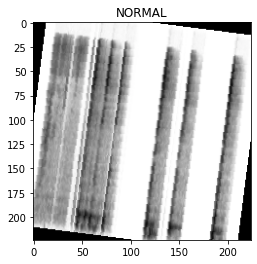

In [30]:
img,label = trainset[20]
#print(trainset.class_to_idx)

class_name =["NORMAL","POSITIVE"]
show_image(img,class_name[label])

In [31]:
trainloader = data.DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  3101 / batch_size: 16 = 194(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = data.DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  345 / batch_size: 16 = 22(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = data.DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  383 / batch_size: 16 = 24(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:194
No. of Total examples:3101
No. of batches in validationloader:22
No. of Total examples:345
No. of batches in testloader:24
No. of Total examples:383


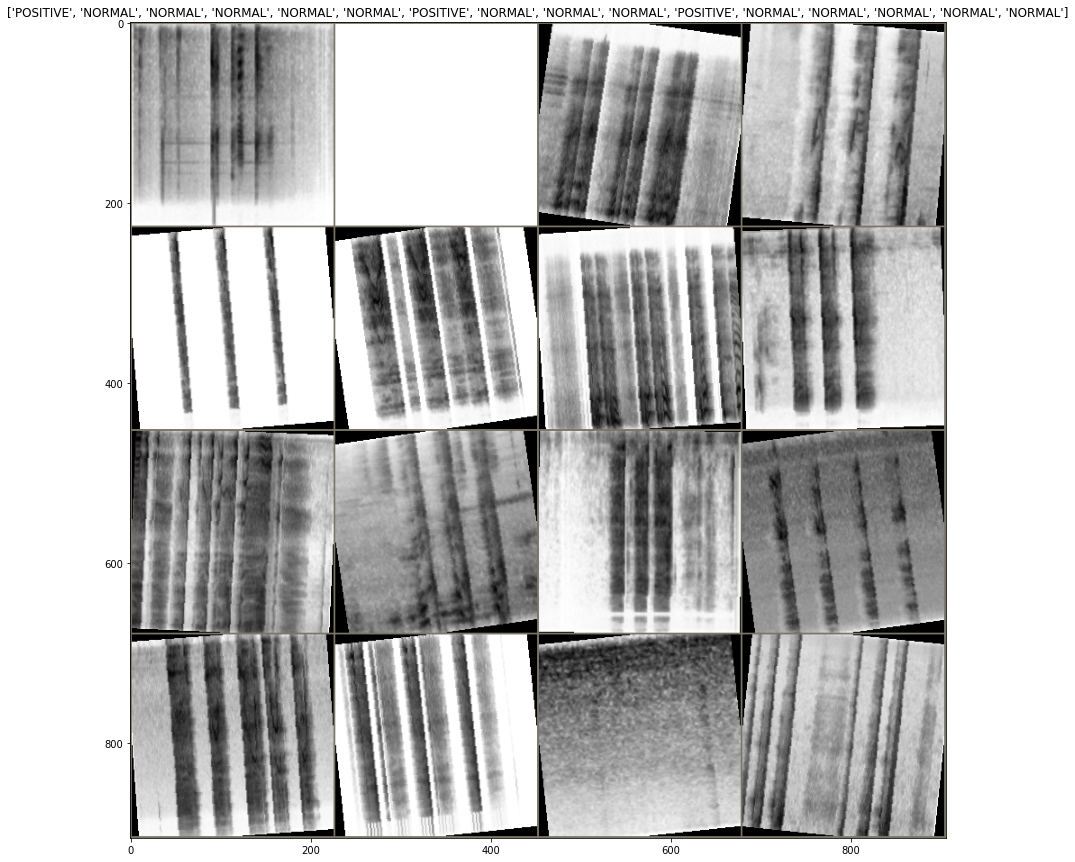

In [32]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

In [33]:
# Load pretrained ResNet50 Model
model_name = 'resnet50'
resnet50_model = timm.create_model('resnet50',pretrained=True) #load pretrained model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


In [34]:
# Freeze model parameters
for param in resnet50_model.parameters():
  param.requires_grad = False

In [35]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Sequential(  nn.Linear(in_features=fc_inputs, out_features=625),
                              nn.ReLU(), #ReLu to be the activation function
                              nn.Dropout(p=0.3),
                              nn.Linear(in_features=625, out_features=256),
                              nn.ReLU(),
                              nn.Linear(in_features=256, out_features=2), 
                              )
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU(inplace=True)
      (downsample): Sequen

In [36]:
# as we are training on GPU. Convert model to be used on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_model.to(device) # move the model to GPU
summary(resnet50_model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [37]:
class COVIDTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
        self.history = []
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm.tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validationloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm.tqdm(validationloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validationloader), valid_acc / len(validationloader)
            
        
    def fit(self,model,trainloader,validationloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validationloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ColabCovidModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))
            self.history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        return self.history

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_model.parameters(),lr = CFG.lr)
trainer = COVIDTrainer(criterion,optimizer)
history = trainer.fit(resnet50_model,trainloader,validationloader,epochs = 25)

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.4156255478208715
Epoch : 1 Train Loss : 0.429598 Train Acc : 0.843279
Epoch : 1 Valid Loss : 0.415626 Valid Acc : 0.845013


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.406968 Train Acc : 0.845138
Epoch : 2 Valid Loss : 0.456078 Valid Acc : 0.842803


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.390769 Train Acc : 0.848186
Epoch : 3 Valid Loss : 0.435931 Valid Acc : 0.847222


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.4156255478208715 --> 0.40450262413783505
Epoch : 4 Train Loss : 0.391658 Train Acc : 0.849648
Epoch : 4 Valid Loss : 0.404503 Valid Acc : 0.869318


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.40450262413783505 --> 0.4023764387450435
Epoch : 5 Train Loss : 0.378925 Train Acc : 0.855274
Epoch : 5 Valid Loss : 0.402376 Valid Acc : 0.866477


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.375005 Train Acc : 0.857851
Epoch : 6 Valid Loss : 0.418410 Valid Acc : 0.862058


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.377780 Train Acc : 0.859536
Epoch : 7 Valid Loss : 0.439936 Valid Acc : 0.864268


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.4023764387450435 --> 0.39835267988118256
Epoch : 8 Train Loss : 0.377477 Train Acc : 0.864616
Epoch : 8 Valid Loss : 0.398353 Valid Acc : 0.872159


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.367859 Train Acc : 0.867045
Epoch : 9 Valid Loss : 0.404985 Valid Acc : 0.862689


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.373468 Train Acc : 0.863006
Epoch : 10 Valid Loss : 0.400622 Valid Acc : 0.866477


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.39835267988118256 --> 0.39595815471627493
Epoch : 11 Train Loss : 0.360513 Train Acc : 0.864146
Epoch : 11 Valid Loss : 0.395958 Valid Acc : 0.861427


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.367038 Train Acc : 0.862460
Epoch : 12 Valid Loss : 0.396589 Valid Acc : 0.855745


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.364277 Train Acc : 0.859561
Epoch : 13 Valid Loss : 0.405755 Valid Acc : 0.860480


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.39595815471627493 --> 0.3914254978299141
Epoch : 14 Train Loss : 0.355687 Train Acc : 0.869375
Epoch : 14 Valid Loss : 0.391425 Valid Acc : 0.867109


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.358009 Train Acc : 0.864963
Epoch : 15 Valid Loss : 0.407314 Valid Acc : 0.859848


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.361763 Train Acc : 0.864220
Epoch : 16 Valid Loss : 0.404726 Valid Acc : 0.864899


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.3914254978299141 --> 0.3908041434531862
Epoch : 17 Train Loss : 0.362262 Train Acc : 0.862361
Epoch : 17 Valid Loss : 0.390804 Valid Acc : 0.867109


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.360904 Train Acc : 0.866302
Epoch : 18 Valid Loss : 0.401461 Valid Acc : 0.869318


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.353295 Train Acc : 0.863898
Epoch : 19 Valid Loss : 0.397118 Valid Acc : 0.864268


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.355500 Train Acc : 0.868904
Epoch : 20 Valid Loss : 0.395714 Valid Acc : 0.866477


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.346925 Train Acc : 0.869697
Epoch : 21 Valid Loss : 0.400967 Valid Acc : 0.864899


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.355558 Train Acc : 0.865657
Epoch : 22 Valid Loss : 0.392996 Valid Acc : 0.864268


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.340862 Train Acc : 0.872671
Epoch : 23 Valid Loss : 0.394103 Valid Acc : 0.861427


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.351038 Train Acc : 0.867590
Epoch : 24 Valid Loss : 0.393270 Valid Acc : 0.864268


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.345911 Train Acc : 0.873241
Epoch : 25 Valid Loss : 0.396936 Valid Acc : 0.863636


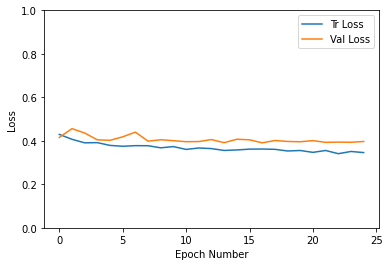

In [39]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

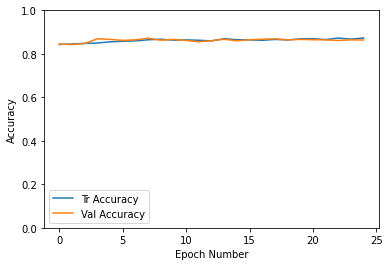

In [40]:

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [42]:
def computeTestSetAccuracy(model, criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Set to evaluation mode
    model.eval()

    # Validation loop
    y_pred_list = []
    y_true_list = []
    for j, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass - compute outputs on input data using the model
        logits = model(images)

        y_true_list.append(labels.data.to("cpu").tolist())
        #y_pred_list.append(logits.to("cpu").tolist())
        y_pred = F.softmax(logits,dim = 1)
        top_p,top_class = y_pred.topk(1,dim = 1)
        y_pred_list.append(top_class.data.to("cpu").tolist())

        loss = criterion(logits,labels)
        test_loss += loss.item()
        test_acc += accuracy(logits,labels)

    return y_pred_list, y_true_list


In [43]:
resnet50_model.load_state_dict(torch.load('/content/ColabCovidModel.pt'))
resnet50_model.eval()
avg_test_loss, avg_test_acc = trainer.valid_batch_loop(resnet50_model,testloader)
print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))
y_pred_list, y_true_list = computeTestSetAccuracy(resnet50_model, criterion)
y_pred_list = [j for i in y_pred_list for j in i]
y_true_list = [j for i in y_true_list for j in i]
print(classification_report(y_true_list, y_pred_list, digits=3))

  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss : 0.37162227494021255
Test Acc : 0.8590278029441833
              precision    recall  f1-score   support

           0      0.857     1.000     0.923       324
           1      1.000     0.085     0.156        59

    accuracy                          0.859       383
   macro avg      0.929     0.542     0.540       383
weighted avg      0.879     0.859     0.805       383



In [44]:
# Repeating same proceduce with efficientNetv2
model_name = 'efficientnetv2_rw_m'
efficientnetv2_model = timm.create_model(model_name,pretrained=True) #load pretrained model
# Freeze model parameters
for param in efficientnetv2_model.parameters():
  param.requires_grad = False
  # Change the final layer of Efficientnetv2 Model for Transfer Learning
#we are updating it as a 2-class classifier:
efficientnetv2_model.classifier = nn.Sequential(
    nn.Linear(in_features=2152, out_features=625), #2152 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

efficientnetv2_model


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnetv2_rw_m_agc-3d90cb1e.pth" to /root/.cache/torch/hub/checkpoints/efficientnetv2_rw_m_agc-3d90cb1e.pth


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): Identity()
        (conv_pwl): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): I

In [45]:
# as we are training on GPU. Convert model to be used on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnetv2_model.to(device) # move the model to GPU
summary(efficientnetv2_model,input_size=(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
          Identity-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]           1,024
       BatchNorm2d-9         [-1, 32, 112, 112]              64
     EdgeResidual-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 32, 112, 112]           9,216
      BatchNorm2d-12         [-1, 32, 112, 112]              64
             SiLU-13         [-1, 32, 112, 112]               0
         Identity-14         [-1, 32, 1

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnetv2_model.parameters(),lr = CFG.lr)
trainer = COVIDTrainer(criterion,optimizer)
history = trainer.fit(efficientnetv2_model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.4161635691469366
Epoch : 1 Train Loss : 0.428684 Train Acc : 0.842808
Epoch : 1 Valid Loss : 0.416164 Valid Acc : 0.847222


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.4161635691469366 --> 0.38649759780276904
Epoch : 2 Train Loss : 0.406090 Train Acc : 0.853018
Epoch : 2 Valid Loss : 0.386498 Valid Acc : 0.866477


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.390705 Train Acc : 0.859635
Epoch : 3 Valid Loss : 0.408396 Valid Acc : 0.858586


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.385529 Train Acc : 0.859462
Epoch : 4 Valid Loss : 0.403353 Valid Acc : 0.850694


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.382545 Train Acc : 0.861246
Epoch : 5 Valid Loss : 0.391432 Valid Acc : 0.856376


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.38649759780276904 --> 0.37159764157100156
Epoch : 6 Train Loss : 0.375572 Train Acc : 0.861395
Epoch : 6 Valid Loss : 0.371598 Valid Acc : 0.877841


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.371103 Train Acc : 0.861667
Epoch : 7 Valid Loss : 0.396936 Valid Acc : 0.864268


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.365449 Train Acc : 0.865756
Epoch : 8 Valid Loss : 0.417625 Valid Acc : 0.859217


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.363274 Train Acc : 0.864790
Epoch : 9 Valid Loss : 0.384048 Valid Acc : 0.872159


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.365497 Train Acc : 0.864071
Epoch : 10 Valid Loss : 0.382550 Valid Acc : 0.860795


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.360142 Train Acc : 0.865905
Epoch : 11 Valid Loss : 0.378781 Valid Acc : 0.866477


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.356899 Train Acc : 0.867590
Epoch : 12 Valid Loss : 0.382363 Valid Acc : 0.867740


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.359320 Train Acc : 0.866797
Epoch : 13 Valid Loss : 0.402328 Valid Acc : 0.867109


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.358294 Train Acc : 0.868408
Epoch : 14 Valid Loss : 0.452303 Valid Acc : 0.862058


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.37159764157100156 --> 0.37108240547505295
Epoch : 15 Train Loss : 0.359941 Train Acc : 0.866078
Epoch : 15 Valid Loss : 0.371082 Valid Acc : 0.869318


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.354099 Train Acc : 0.869127
Epoch : 16 Valid Loss : 0.382667 Valid Acc : 0.869318


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.353897 Train Acc : 0.865657
Epoch : 17 Valid Loss : 0.380344 Valid Acc : 0.864268


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.355341 Train Acc : 0.869127
Epoch : 18 Valid Loss : 0.379416 Valid Acc : 0.869318


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.37108240547505295 --> 0.35197945548729465
Epoch : 19 Train Loss : 0.351096 Train Acc : 0.869622
Epoch : 19 Valid Loss : 0.351979 Valid Acc : 0.869950


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.355306 Train Acc : 0.867194
Epoch : 20 Valid Loss : 0.371651 Valid Acc : 0.849116


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.355441 Train Acc : 0.866004
Epoch : 21 Valid Loss : 0.425251 Valid Acc : 0.869318


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.345595 Train Acc : 0.868482
Epoch : 22 Valid Loss : 0.371352 Valid Acc : 0.858586


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.339444 Train Acc : 0.872671
Epoch : 23 Valid Loss : 0.383462 Valid Acc : 0.861427


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.343977 Train Acc : 0.871233
Epoch : 24 Valid Loss : 0.376498 Valid Acc : 0.856376


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.340480 Train Acc : 0.870663
Epoch : 25 Valid Loss : 0.438192 Valid Acc : 0.856376


In [47]:
###Data Preparation - Class Imbalance - Imbalanced Dataset Sampler
# (https://github.com/ufoym/imbalanced-dataset-sampler) Minority upsampling
trainloader = data.DataLoader( trainset, sampler=ImbalancedDatasetSampler(trainset), batch_size=CFG.batch_size)

print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  3101 / batch_size: 16 = 194(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = data.DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  345 / batch_size: 16 = 22(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = data.DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  383 / batch_size: 16 = 24(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:194
No. of Total examples:3101
No. of batches in validationloader:22
No. of Total examples:345
No. of batches in testloader:24
No. of Total examples:383


In [49]:
# Load pretrained ResNet50 again
model_name = 'resnet50'
resnet50_model = timm.create_model('resnet50',pretrained=True) #load pretrained model
for param in resnet50_model.parameters():
  param.requires_grad = False

fc_inputs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Sequential(  nn.Linear(in_features=fc_inputs, out_features=625),
                              nn.ReLU(), #ReLu to be the activation function
                              nn.Dropout(p=0.3),
                              nn.Linear(in_features=625, out_features=256),
                              nn.ReLU(),
                              nn.Linear(in_features=256, out_features=2), 
                              )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_model.to(device) # move the model to GPU
summary(resnet50_model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_model.parameters(),lr = CFG.lr)
trainer = COVIDTrainer(criterion,optimizer)
history = trainer.fit(resnet50_model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.9088953719897703
Epoch : 1 Train Loss : 0.658046 Train Acc : 0.617293
Epoch : 1 Valid Loss : 0.908895 Valid Acc : 0.409722


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.9088953719897703 --> 0.8930503536354412
Epoch : 2 Train Loss : 0.621284 Train Acc : 0.654168
Epoch : 2 Valid Loss : 0.893050 Valid Acc : 0.519571


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.8930503536354412 --> 0.5743951892310922
Epoch : 3 Train Loss : 0.610618 Train Acc : 0.664304
Epoch : 3 Valid Loss : 0.574395 Valid Acc : 0.745581


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.5743951892310922 --> 0.568264436992732
Epoch : 4 Train Loss : 0.599858 Train Acc : 0.673994
Epoch : 4 Valid Loss : 0.568264 Valid Acc : 0.768308


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.593467 Train Acc : 0.685617
Epoch : 5 Valid Loss : 0.580281 Valid Acc : 0.705177


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.568264436992732 --> 0.5500220534476367
Epoch : 6 Train Loss : 0.589602 Train Acc : 0.690325
Epoch : 6 Valid Loss : 0.550022 Valid Acc : 0.760417


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.586887 Train Acc : 0.689706
Epoch : 7 Valid Loss : 0.657140 Valid Acc : 0.595644


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.584831 Train Acc : 0.678207
Epoch : 8 Valid Loss : 0.760708 Valid Acc : 0.446338


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.566002 Train Acc : 0.720485
Epoch : 9 Valid Loss : 0.598735 Valid Acc : 0.706439


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.5500220534476367 --> 0.5496680993925441
Epoch : 10 Train Loss : 0.566029 Train Acc : 0.701774
Epoch : 10 Valid Loss : 0.549668 Valid Acc : 0.791035


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.568882 Train Acc : 0.704277
Epoch : 11 Valid Loss : 0.555965 Valid Acc : 0.779672


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.563993 Train Acc : 0.696545
Epoch : 12 Valid Loss : 0.667490 Valid Acc : 0.627525


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.566968 Train Acc : 0.693795
Epoch : 13 Valid Loss : 0.789597 Valid Acc : 0.491162


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.573322 Train Acc : 0.697735
Epoch : 14 Valid Loss : 0.624962 Valid Acc : 0.665720


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.5496680993925441 --> 0.5375877930359407
Epoch : 15 Train Loss : 0.549146 Train Acc : 0.715404
Epoch : 15 Valid Loss : 0.537588 Valid Acc : 0.724116


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.560294 Train Acc : 0.690821
Epoch : 16 Valid Loss : 0.646043 Valid Acc : 0.668245


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.5375877930359407 --> 0.5108856640078805
Epoch : 17 Train Loss : 0.561152 Train Acc : 0.706780
Epoch : 17 Valid Loss : 0.510886 Valid Acc : 0.776200


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.564834 Train Acc : 0.696124
Epoch : 18 Valid Loss : 0.709844 Valid Acc : 0.579230


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.549180 Train Acc : 0.714438
Epoch : 19 Valid Loss : 0.661830 Valid Acc : 0.643308


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.549674 Train Acc : 0.712654
Epoch : 20 Valid Loss : 0.543344 Valid Acc : 0.764836


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.542679 Train Acc : 0.726903
Epoch : 21 Valid Loss : 0.714977 Valid Acc : 0.555240


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.539069 Train Acc : 0.713620
Epoch : 22 Valid Loss : 0.579913 Valid Acc : 0.680871


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.535466 Train Acc : 0.732306
Epoch : 23 Valid Loss : 0.622297 Valid Acc : 0.658775


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.553921 Train Acc : 0.715008
Epoch : 24 Valid Loss : 0.580793 Valid Acc : 0.671402


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.526691 Train Acc : 0.732628
Epoch : 25 Valid Loss : 0.591663 Valid Acc : 0.678030


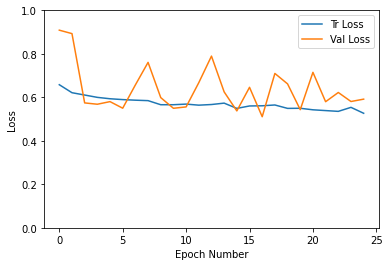

In [52]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

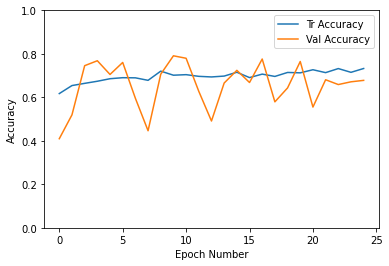

In [53]:

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [54]:
resnet50_model.load_state_dict(torch.load('/content/ColabCovidModel.pt'))
resnet50_model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(resnet50_model,testloader)

print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss : 0.496903491516908
Test Acc : 0.793749988079071


In [55]:
y_pred_list, y_true_list = computeTestSetAccuracy(resnet50_model, criterion)
y_pred_list = [j for i in y_pred_list for j in i]
y_true_list = [j for i in y_true_list for j in i]
print(classification_report(y_true_list, y_pred_list, digits=3))

              precision    recall  f1-score   support

           0      0.894     0.858     0.876       324
           1      0.361     0.441     0.397        59

    accuracy                          0.794       383
   macro avg      0.628     0.649     0.636       383
weighted avg      0.812     0.794     0.802       383



In [51]:
model_name = 'efficientnetv2_rw_m'
efficientnetv2_model = timm.create_model(model_name,pretrained=True) #load pretrained model
# Freeze model parameters
for param in efficientnetv2_model.parameters():
  param.requires_grad = False

# Change the final layer of Efficientnetv2 Model for Transfer Learning
#we are updating it as a 2-class classifier:
efficientnetv2_model.classifier = nn.Sequential(
    nn.Linear(in_features=2152, out_features=625), #2152 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnetv2_model.to(device) # move the model to GPU
summary(efficientnetv2_model,input_size=(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
          Identity-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]           1,024
       BatchNorm2d-9         [-1, 32, 112, 112]              64
     EdgeResidual-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 32, 112, 112]           9,216
      BatchNorm2d-12         [-1, 32, 112, 112]              64
             SiLU-13         [-1, 32, 112, 112]               0
         Identity-14         [-1, 32, 1

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnetv2_model.parameters(),lr = CFG.lr)
trainer = COVIDTrainer(criterion,optimizer)
history = trainer.fit(efficientnetv2_model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.7767680206082084
Epoch : 1 Train Loss : 0.642601 Train Acc : 0.625694
Epoch : 1 Valid Loss : 0.776768 Valid Acc : 0.564394


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.7767680206082084 --> 0.768528239293532
Epoch : 2 Train Loss : 0.612111 Train Acc : 0.662148
Epoch : 2 Valid Loss : 0.768528 Valid Acc : 0.565657


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.768528239293532 --> 0.5407837669957768
Epoch : 3 Train Loss : 0.594290 Train Acc : 0.678504
Epoch : 3 Valid Loss : 0.540784 Valid Acc : 0.759154


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.581704 Train Acc : 0.692432
Epoch : 4 Valid Loss : 0.757898 Valid Acc : 0.545770


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.582370 Train Acc : 0.681974
Epoch : 5 Valid Loss : 0.764164 Valid Acc : 0.526831


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.569636 Train Acc : 0.703633
Epoch : 6 Valid Loss : 0.759396 Valid Acc : 0.520202


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.576113 Train Acc : 0.697586
Epoch : 7 Valid Loss : 0.605742 Valid Acc : 0.729167


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.569635 Train Acc : 0.699594
Epoch : 8 Valid Loss : 0.585665 Valid Acc : 0.721275


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.564659 Train Acc : 0.692184
Epoch : 9 Valid Loss : 0.624160 Valid Acc : 0.627525


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.552323 Train Acc : 0.715875
Epoch : 10 Valid Loss : 0.555095 Valid Acc : 0.702967


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.563854 Train Acc : 0.696298
Epoch : 11 Valid Loss : 0.671453 Valid Acc : 0.667298


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.547321 Train Acc : 0.716495
Epoch : 12 Valid Loss : 0.769549 Valid Acc : 0.545770


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.540411 Train Acc : 0.722418
Epoch : 13 Valid Loss : 0.592687 Valid Acc : 0.725063


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.556232 Train Acc : 0.704847
Epoch : 14 Valid Loss : 0.604488 Valid Acc : 0.702020


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.542195 Train Acc : 0.715950
Epoch : 15 Valid Loss : 0.545455 Valid Acc : 0.737058


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.554021 Train Acc : 0.715305
Epoch : 16 Valid Loss : 0.576941 Valid Acc : 0.712121


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.543315 Train Acc : 0.706607
Epoch : 17 Valid Loss : 0.599377 Valid Acc : 0.705177


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.529709 Train Acc : 0.723781
Epoch : 18 Valid Loss : 0.577575 Valid Acc : 0.732008


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.545950 Train Acc : 0.711514
Epoch : 19 Valid Loss : 0.644146 Valid Acc : 0.655934


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.541407 Train Acc : 0.713125
Epoch : 20 Valid Loss : 0.549445 Valid Acc : 0.744950


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.527818 Train Acc : 0.721674
Epoch : 21 Valid Loss : 0.561788 Valid Acc : 0.730745


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.529364 Train Acc : 0.719964
Epoch : 22 Valid Loss : 0.559415 Valid Acc : 0.728535


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.545290 Train Acc : 0.712480
Epoch : 23 Valid Loss : 0.564677 Valid Acc : 0.718434


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.5407837669957768 --> 0.48600069365718146
Epoch : 24 Train Loss : 0.531437 Train Acc : 0.725565
Epoch : 24 Valid Loss : 0.486001 Valid Acc : 0.772412


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.539481 Train Acc : 0.709432
Epoch : 25 Valid Loss : 0.557820 Valid Acc : 0.732639


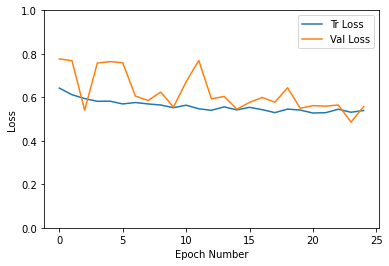

In [58]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

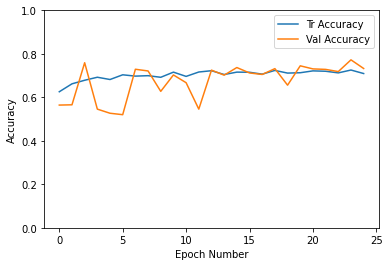

In [59]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [60]:
efficientnetv2_model.load_state_dict(torch.load('/content/ColabCovidModel.pt'))
efficientnetv2_model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(efficientnetv2_model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss : 0.46818286553025246
Test Acc : 0.7888888716697693


In [61]:
y_pred_list, y_true_list = computeTestSetAccuracy(efficientnetv2_model, criterion)

y_pred_list = [j for i in y_pred_list for j in i]
y_true_list = [j for i in y_true_list for j in i]

print(classification_report(y_true_list, y_pred_list, digits=3))

              precision    recall  f1-score   support

           0      0.896     0.849     0.872       324
           1      0.355     0.458     0.400        59

    accuracy                          0.789       383
   macro avg      0.626     0.653     0.636       383
weighted avg      0.813     0.789     0.799       383



In [62]:
#Weighted Random Sampler
# https://github.com/pytorch/pytorch/blob/master/torch/utils/data/sampler.py#L73-L90

train_classes = [label for _, label in trainset]
# Need to get weight for every image in the dataset
class_count = Counter(train_classes)
class_weights = torch.Tensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Can't iterate over class_count because dictionary is unordered

sample_weights = [0] * len(trainset)
for idx, (image, label) in enumerate(trainset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples = len(trainset), replacement=True)  

In [63]:
trainloader = data.DataLoader( trainset, sampler=sampler, batch_size=CFG.batch_size)

print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  3101 / batch_size: 16 = 194(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = data.DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  345 / batch_size: 16 = 22(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = data.DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  383 / batch_size: 16 = 24(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:194
No. of Total examples:3101
No. of batches in validationloader:22
No. of Total examples:345
No. of batches in testloader:24
No. of Total examples:383


In [64]:
#Load resnet again for weighted sampler
model_name = 'resnet50'
resnet50_model = timm.create_model('resnet50',pretrained=True) #load pretrained model

In [65]:
for param in resnet50_model.parameters():
  param.requires_grad = False

fc_inputs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Sequential(  nn.Linear(in_features=fc_inputs, out_features=625),
                              nn.ReLU(), #ReLu to be the activation function
                              nn.Dropout(p=0.3),
                              nn.Linear(in_features=625, out_features=256),
                              nn.ReLU(),
                              nn.Linear(in_features=256, out_features=2), 
                              )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_model.to(device) # move the model to GPU
summary(resnet50_model,input_size=(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_model.parameters(),lr = CFG.lr)
trainer = COVIDTrainer(criterion,optimizer)
history = trainer.fit(resnet50_model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.6143149923194539
Epoch : 1 Train Loss : 0.679380 Train Acc : 0.580987
Epoch : 1 Valid Loss : 0.614315 Valid Acc : 0.689394


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.638004 Train Acc : 0.637515
Epoch : 2 Valid Loss : 0.706130 Valid Acc : 0.504735


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.6143149923194539 --> 0.5031607327136126
Epoch : 3 Train Loss : 0.604313 Train Acc : 0.678678
Epoch : 3 Valid Loss : 0.503161 Valid Acc : 0.797348


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.595845 Train Acc : 0.672631
Epoch : 4 Valid Loss : 0.758620 Valid Acc : 0.553662


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.597880 Train Acc : 0.677463
Epoch : 5 Valid Loss : 0.893026 Valid Acc : 0.395833


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.590200 Train Acc : 0.685914
Epoch : 6 Valid Loss : 0.616490 Valid Acc : 0.711490


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.583365 Train Acc : 0.687525
Epoch : 7 Valid Loss : 0.589226 Valid Acc : 0.750631


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.568747 Train Acc : 0.703559
Epoch : 8 Valid Loss : 0.652521 Valid Acc : 0.616162


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.574987 Train Acc : 0.696967
Epoch : 9 Valid Loss : 0.622002 Valid Acc : 0.697285


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.572495 Train Acc : 0.706458
Epoch : 10 Valid Loss : 0.557094 Valid Acc : 0.766730


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.565652 Train Acc : 0.706532
Epoch : 11 Valid Loss : 0.592073 Valid Acc : 0.751894


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.558565 Train Acc : 0.710151
Epoch : 12 Valid Loss : 0.693327 Valid Acc : 0.616162


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.563447 Train Acc : 0.695505
Epoch : 13 Valid Loss : 0.624465 Valid Acc : 0.717172


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.558514 Train Acc : 0.704277
Epoch : 14 Valid Loss : 0.753698 Valid Acc : 0.597538


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.567842 Train Acc : 0.701378
Epoch : 15 Valid Loss : 0.669318 Valid Acc : 0.708649


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.557406 Train Acc : 0.719493
Epoch : 16 Valid Loss : 0.591754 Valid Acc : 0.738321


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.545987 Train Acc : 0.714834
Epoch : 17 Valid Loss : 0.610063 Valid Acc : 0.695707


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.531901 Train Acc : 0.722864
Epoch : 18 Valid Loss : 0.650549 Valid Acc : 0.663194


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.564547 Train Acc : 0.692283
Epoch : 19 Valid Loss : 0.714575 Valid Acc : 0.590593


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.542472 Train Acc : 0.717883
Epoch : 20 Valid Loss : 0.653585 Valid Acc : 0.695076


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.535671 Train Acc : 0.724029
Epoch : 21 Valid Loss : 0.621408 Valid Acc : 0.699495


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.547994 Train Acc : 0.721278
Epoch : 22 Valid Loss : 0.763189 Valid Acc : 0.539457


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.543378 Train Acc : 0.709358
Epoch : 23 Valid Loss : 0.550315 Valid Acc : 0.754104


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.535777 Train Acc : 0.725615
Epoch : 24 Valid Loss : 0.640439 Valid Acc : 0.695707


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.534909 Train Acc : 0.724896
Epoch : 25 Valid Loss : 0.529357 Valid Acc : 0.774621


In [67]:
resnet50_model.load_state_dict(torch.load('/content/ColabCovidModel.pt'))
resnet50_model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(resnet50_model,testloader)

print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss : 0.4777427688241005
Test Acc : 0.8279513716697693


In [68]:
y_pred_list, y_true_list = computeTestSetAccuracy(resnet50_model, criterion)
y_pred_list = [j for i in y_pred_list for j in i]
y_true_list = [j for i in y_true_list for j in i]
print(classification_report(y_true_list, y_pred_list, digits=3))

              precision    recall  f1-score   support

           0      0.891     0.907     0.899       324
           1      0.434     0.390     0.411        59

    accuracy                          0.828       383
   macro avg      0.662     0.649     0.655       383
weighted avg      0.821     0.828     0.824       383



In [69]:
# Load eff net for weighted sampler
model_name = 'efficientnetv2_rw_m'
efficientnetv2_model = timm.create_model(model_name,pretrained=True) #load pretrained model
for param in efficientnetv2_model.parameters():
  param.requires_grad = False

# Change the final layer of Efficientnetv2 Model for Transfer Learning
#we are updating it as a 2-class classifier:
efficientnetv2_model.classifier = nn.Sequential(
    nn.Linear(in_features=2152, out_features=625), #2152 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnetv2_model.to(device) # move the model to GPU
summary(efficientnetv2_model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
          Identity-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]           1,024
       BatchNorm2d-9         [-1, 32, 112, 112]              64
     EdgeResidual-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 32, 112, 112]           9,216
      BatchNorm2d-12         [-1, 32, 112, 112]              64
             SiLU-13         [-1, 32, 112, 112]               0
         Identity-14         [-1, 32, 1

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnetv2_model.parameters(),lr = CFG.lr)
trainer = COVIDTrainer(criterion,optimizer)
history = trainer.fit(efficientnetv2_model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.6204943805932999
Epoch : 1 Train Loss : 0.638946 Train Acc : 0.626313
Epoch : 1 Valid Loss : 0.620494 Valid Acc : 0.742740


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.616951 Train Acc : 0.662817
Epoch : 2 Valid Loss : 0.843054 Valid Acc : 0.430871


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.586867 Train Acc : 0.685666
Epoch : 3 Valid Loss : 0.638032 Valid Acc : 0.621843


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.6204943805932999 --> 0.5931713283061981
Epoch : 4 Train Loss : 0.589174 Train Acc : 0.675927
Epoch : 4 Valid Loss : 0.593171 Valid Acc : 0.664773


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.582169 Train Acc : 0.680908
Epoch : 5 Valid Loss : 0.613946 Valid Acc : 0.708018


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.576807 Train Acc : 0.690672
Epoch : 6 Valid Loss : 0.657187 Valid Acc : 0.651200


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.571626 Train Acc : 0.694538
Epoch : 7 Valid Loss : 0.625680 Valid Acc : 0.688447


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.567417 Train Acc : 0.696223
Epoch : 8 Valid Loss : 0.793218 Valid Acc : 0.482639


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.555777 Train Acc : 0.713125
Epoch : 9 Valid Loss : 0.795652 Valid Acc : 0.598485


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.558204 Train Acc : 0.704030
Epoch : 10 Valid Loss : 0.700553 Valid Acc : 0.604167


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.559890 Train Acc : 0.697264
Epoch : 11 Valid Loss : 0.647487 Valid Acc : 0.646780


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.546676 Train Acc : 0.711068
Epoch : 12 Valid Loss : 0.608426 Valid Acc : 0.659091


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.546570 Train Acc : 0.715702
Epoch : 13 Valid Loss : 0.627718 Valid Acc : 0.668876


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.5931713283061981 --> 0.5446525893428109
Epoch : 14 Train Loss : 0.547670 Train Acc : 0.717957
Epoch : 14 Valid Loss : 0.544653 Valid Acc : 0.711490


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.5446525893428109 --> 0.5264258167960427
Epoch : 15 Train Loss : 0.546586 Train Acc : 0.710968
Epoch : 15 Valid Loss : 0.526426 Valid Acc : 0.731376


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.534004 Train Acc : 0.723607
Epoch : 16 Valid Loss : 0.635239 Valid Acc : 0.655303


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.537123 Train Acc : 0.720856
Epoch : 17 Valid Loss : 0.560884 Valid Acc : 0.697917


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.542785 Train Acc : 0.704624
Epoch : 18 Valid Loss : 0.541317 Valid Acc : 0.708018


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.556229 Train Acc : 0.709506
Epoch : 19 Valid Loss : 0.543298 Valid Acc : 0.709912


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.541091 Train Acc : 0.718130
Epoch : 20 Valid Loss : 1.570216 Valid Acc : 0.548611


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.522535 Train Acc : 0.734809
Epoch : 21 Valid Loss : 0.672795 Valid Acc : 0.599747


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Valid_loss decreased 0.5264258167960427 --> 0.5254639454863288
Epoch : 22 Train Loss : 0.510193 Train Acc : 0.746407
Epoch : 22 Valid Loss : 0.525464 Valid Acc : 0.749684


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.534423 Train Acc : 0.718527
Epoch : 23 Valid Loss : 0.605461 Valid Acc : 0.658144


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.541650 Train Acc : 0.717164
Epoch : 24 Valid Loss : 0.555051 Valid Acc : 0.734848


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.539301 Train Acc : 0.721104
Epoch : 25 Valid Loss : 0.670851 Valid Acc : 0.631313


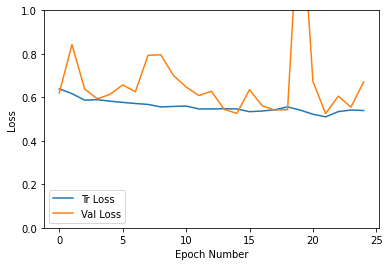

In [71]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

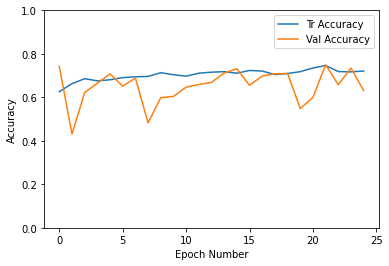

In [72]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()


In [73]:
efficientnetv2_model.load_state_dict(torch.load('/content/ColabCovidModel.pt'))
efficientnetv2_model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(efficientnetv2_model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss : 0.49070653443535167
Test Acc : 0.7572916150093079


In [74]:
#getting the classification report
y_pred_list, y_true_list = computeTestSetAccuracy(efficientnetv2_model, criterion)

y_pred_list = [j for i in y_pred_list for j in i]
y_true_list = [j for i in y_true_list for j in i]

print(classification_report(y_true_list, y_pred_list, digits=3))

              precision    recall  f1-score   support

           0      0.902     0.799     0.848       324
           1      0.323     0.525     0.400        59

    accuracy                          0.757       383
   macro avg      0.613     0.662     0.624       383
weighted avg      0.813     0.757     0.779       383

